In [1]:
# !pip install line-bot-sdk
# !git clone https://github.com/SparklePh/Seagate_Workshop
# !pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 11.9 MB/s eta 0:00:00
Cloning into 'Seagate_Workshop'...
remote: Enumerating objects: 2708, done.
remote: Total 2708 (delta 0), reused 0 (delta 0), pack-reused 2708 (from 2)
Receiving objects: 100% (2708/2708), 221.68 MiB | 15.81 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (6117/6117), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.8 MB/s eta 0:00:00


In [2]:
# %cd /content/Seagate_Workshop

/content/Seagate_Workshop


# Load model เตรียมไว้

In [3]:
from ultralytics import YOLO

# Load YOLOv8 pretrained model
model = YOLO("/content/Seagate_Workshop/model/yolov8l_car.pt")  # small model for fast inference
model.info()
model.names


YOLOv8l summary: 209 layers, 43,691,520 parameters, 0 gradients, 165.7 GFLOPs


{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

# โค้ด YOLO + Line แจ้งเตือน

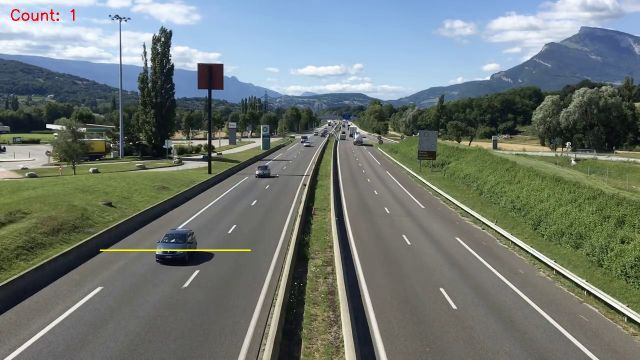

KeyboardInterrupt: 

In [17]:
import cv2
import requests
import base64
from IPython.display import display, Image
from ultralytics import YOLO
from linebot.v3.messaging import Configuration, ApiClient, MessagingApi, TextMessage, ImageMessage, PushMessageRequest

# ==========================================
# 1. ตั้งค่าพื้นฐาน (Configuration)
# ==========================================
ACCESS_TOKEN = ""
USER_ID = ""
IMGBB_API_KEY = ""
VIDEO_PATH = "/content/Seagate_Workshop/data/highway.mp4"

# --- ตั้งค่า Class ที่ต้องการจับ (อ้างอิงจาก COCO Dataset) ---
TARGET_CLASSES = [2]

configuration = Configuration(access_token=ACCESS_TOKEN)


# ==========================================
# 2. ฟังก์ชันอัปโหลดรูปขึ้น ImgBB
# ==========================================
def upload_to_imgbb(image_path, api_key):
    try:
        with open(image_path, "rb") as file:
            payload = {
                "key": api_key,
                "image": base64.b64encode(file.read()),
            }
            response = requests.post("https://api.imgbb.com/1/upload", payload)
            if response.status_code == 200:
                return response.json()['data']['url']
    except Exception as e:
        print(f"Error Uploading: {e}")
    return None

# ==========================================
# 3. ฟังก์ชันแจ้งเตือนผ่าน LINE
# ==========================================
def send_line_alert(count, image_url):
    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)

        text_msg = TextMessage(text=f"📢 แจ้งเตือน! ตรวจพบรถวิ่งผ่านครบ {count} คันแล้วครับ")

        if image_url:
            image_msg = ImageMessage(
                original_content_url=image_url,
                preview_image_url=image_url
            )
            messages = [text_msg, image_msg]
        else:
            messages = [text_msg]

        request = PushMessageRequest(to=USER_ID, messages=messages)
        try:
            line_bot_api.push_message(request)
            print("✅ ส่งแจ้งเตือน LINE เรียบร้อย!")
        except Exception as e:
            print(f"❌ LINE Error: {e}")

def get_object_centers(results):
    centers = []
    ids = []
    if results[0].boxes.id is None:  # ถ้าไม่มีการ track ID
        return centers, ids

    boxes = results[0].boxes.xyxy.cpu().numpy()   # (x1,y1,x2,y2)
    track_ids = results[0].boxes.id.cpu().numpy().astype(int)  # ดึง object IDs

    for box, obj_id in zip(boxes, track_ids):
        x1, y1, x2, y2 = box
        cx, cy = int((x1 + x2)/2), int((y1 + y2)/2)
        centers.append((cx, cy))
        ids.append(obj_id)

    return centers, ids

# ==========================================
# 4. ส่วนของการประมวลผลวิดีโอ (Video Processing)
# ==========================================

# ตั้งค่าเส้น ROI (Region of Interest)
line_y = 500
line_y_band = 10
line_x_start = 200
line_x_end = 500

counted_ids = set()
total_count = 0
alert_triggered = False # ใช้เช็คเพื่อให้แจ้งเตือนครั้งเดียวเมื่อถึง 10
cap = cv2.VideoCapture(VIDEO_PATH)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# ป้องกันกรณีโหลดวิดีโอไม่ได้แล้วค่า fps เป็น 0
if fps == 0:
    fps = 30

# --- ส่วนที่ปรับแก้: สร้างชื่อไฟล์ Output อัตโนมัติจากชื่อไฟล์ Input ---
# เช่น ถ้า VIDEO_PATH = "video/my_street.mp4"
# base_name จะได้ "my_street"
base_name = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
OUTPUT_VIDEO_PATH = f"{base_name}_counted.avi"

# นำตัวแปร OUTPUT_VIDEO_PATH มาใช้แทนชื่อที่ Hardcode ไว้
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))
frame_count = 0
display_every_n_frame = 2

# สร้าง "กรอบรูป" เตรียมไว้ก่อนเข้าลูป (สำหรับการแสดงผลใน Jupyter/Colab)
display_handle = display(None, display_id=True)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # --- ส่ง TARGET_CLASSES ไปกรองวัตถุตั้งแต่ตอนตรวจจับ ---
    results = model.track(frame, conf=0.5, persist=True, verbose=False, classes=TARGET_CLASSES)

    # หากต้องการให้วาดกล่อง Bounding Box ทับลงบนเฟรมวิดีโอด้วย ให้ใช้คำสั่งด้านล่างนี้แทน
    # frame = results[0].plot()

    centers, ids = get_object_centers(results)

    for (cx, cy), obj_id in zip(centers, ids):
        if (line_y - line_y_band < cy < line_y + line_y_band and
            line_x_start <= cx <= line_x_end and
            obj_id not in counted_ids):

            counted_ids.add(obj_id)
            total_count += 1

            # เงื่อนไขแจ้งเตือนเมื่อครบ 10 คัน
            if total_count == 10 and not alert_triggered:
                temp_img = "alert_frame.jpg"
                cv2.imwrite(temp_img, frame)

                img_url = upload_to_imgbb(temp_img, IMGBB_API_KEY)
                send_line_alert(total_count, img_url)
                alert_triggered = True

    # วาดเส้น ROI และข้อความนับจำนวน
    cv2.line(frame, (line_x_start, line_y), (line_x_end, line_y), (0, 255, 255), 2)
    cv2.putText(frame, f"Count: {total_count}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # บันทึกลงไฟล์วิดีโอ
    out.write(frame)

    # โชว์ภาพแบบ In-place Update (ไม่กระพริบ, เร็วขึ้น)
    if frame_count % display_every_n_frame == 0:
        display_frame = cv2.resize(frame, (640, 360))
        _, buffer = cv2.imencode('.jpeg', display_frame, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
        display_handle.update(Image(data=buffer.tobytes()))

cap.release()
out.release()

# --- ส่วนที่ปรับแก้: แสดงชื่อไฟล์ที่บันทึกจริงๆ ---
print(f"✅ ประมวลผลเสร็จสิ้น! บันทึกวิดีโอที่: {OUTPUT_VIDEO_PATH}")

# Download คลิป youtube ทดลอง

In [5]:
!pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.5 MB/s eta 0:00:00


In [ ]:
import yt_dlp

# 1. ใส่ลิงก์ YouTube ที่ต้องการดาวน์โหลด
video_url = "ใส่_ลิงก์_YOUTUBE_ตรงนี้"

# 2. ตั้งค่า (โหลดความละเอียดสูงสุดที่เป็น MP4 และบันทึกไว้ในโฟลเดอร์ /content)
ydl_opts = {
    'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
    'outtmpl': '/content/%(title)s.%(ext)s', # ตั้งชื่อไฟล์ตามชื่อวิดีโอ
    'merge_output_format': 'mp4'
}

# 3. สั่งดาวน์โหลด
print(f"กำลังดาวน์โหลด: {video_url}")
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])
print("✅ ดาวน์โหลดเสร็จสิ้น! ไฟล์อยู่ที่โฟลเดอร์ซ้ายมือ (Files)")